# Index
<ol>
    <li><a href="#setup_and_data_download">Setup and data download</a>
    <li><a href="#data_preprocessing">Data preprocessing</a>
    <li><a href="#training_data_visualization">Training data visualization</a>
    <li><a href="#model_training">Model training</a>
    <li><a href="#model_validation">Model validation</a>
    <li><a href="#model_predictions">Model predictions</a>
       
           
            

<br>
<br>
<a id="setup_and_data_download"> </a>
# 1. Setup and data download

<br>
## 1.1 Libraries setup

### Import the fastai library

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *

### Import functionality libraries

In [3]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp # Exponential function
from sklearn.metrics import classification_report, precision_recall_fscore_support, fbeta_score # Useful metrics for single label classification
import time # Measuring elapsed time
import itertools as it
from torch import FloatTensor

### Check CUDA is enabled

It's important that you have a working Nvidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA.

In [4]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN

In [5]:
torch.backends.cudnn.enabled

True

<br>
## 1.2 Enviroment setup

### Environment

The environment overview

```
./input
│      
│
└─── train
│   │   train.csv
│   │   oil.csv
│
│
└─── test
│   │   test.csv
│   │ 
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Windows or Unix
Set the separators depending on the OS

In [6]:
OS = "Windows"

In [7]:
if OS == "Windows":
    s = "\\"
elif OS == "Linux":
    s = "/"
else:
    print("Not a valid OS")

### Initialize the environment variables

In [8]:
TRAIN_DIR = "train"
TEST_DIR = "test"
SUBMISSION_DIR = "submission"
INPUT_PATH = f'.{s}input'
TRAIN_PATH = f'{INPUT_PATH}{s}{TRAIN_DIR}'
TEST_PATH = f'{INPUT_PATH}{s}{TEST_DIR}'
SUBMISSION_PATH = f'{INPUT_PATH}{s}{SUBMISSION_DIR}'
DOWNLOAD_PATH = "C:\\Users\\David\\.kaggle\\competitions\\avito-demand-prediction"

<br>
## 1.2 Data setup

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api <br>
Remember to accept the rules of the competition, otherwise it won't work.

Files for the structured neural network:

In [9]:
structured_files = ["train.csv.zip", "train_active.csv.zip", "periods_train.csv.zip",
                    "test.csv.zip", "test_active.csv.zip", "periods_test.csv.zip"]

In [10]:
download_all_data = False

In [11]:
if download_all_data:
    for file in structured_files:
        print(f"Downloading {file}...")
        os.system(f'kaggle competitions download -c avito-demand-prediction -f {file}')
    print("Compressed files ready")

### Create the input directory

In [12]:
if not os.path.exists(f'{INPUT_PATH}'):
    os.mkdir(f'{INPUT_PATH}')

### Extract the data to the input directory

Check the download directory.<br>
As we can see, we have a bunch of csv files containing data.

In [13]:
os.listdir(DOWNLOAD_PATH)

['periods_test.csv.zip',
 'periods_train.csv.zip',
 'test.csv.zip',
 'test_active.csv.zip',
 'train.csv.zip',
 'train_active.csv.zip']

### Create the train, test and submission directory

In [14]:
if not os.path.exists(TRAIN_PATH): 
    os.mkdir(TRAIN_PATH)
print("Train directory ready")

if not os.path.exists(TEST_PATH): 
    os.mkdir(TEST_PATH)
print("Test directory ready")

if not os.path.exists(SUBMISSION_PATH): 
    os.mkdir(SUBMISSION_PATH)
print("Submmission directory ready")

Train directory ready
Test directory ready
Submmission directory ready


### Extract the data

Extract the data in the train directory and submission directory.<br>
Set the flag to false when already extracted.

In [15]:
extract_data = False

In [16]:
train_csv_files = ["train.csv.zip", "train_active.csv.zip", "periods_train.csv.zip"]
test_csv_files = ["test.csv.zip", "test_active.csv.zip", "periods_test.csv.zip"]
submission_csv_files = []

In [17]:
if extract_data:
    for csv_file in train_csv_files:
        csv_zip = zipfile.ZipFile(f'{DOWNLOAD_PATH}{s}{csv_file}', mode="r")
        csv_zip.extractall(TRAIN_PATH)
        csv_zip.close()
    for csv_file in test_csv_files:
        csv_zip = zipfile.ZipFile(f'{DOWNLOAD_PATH}{s}{csv_file}', mode="r")
        csv_zip.extractall(TEST_PATH)
        csv_zip.close()

    for csv_file in submission_csv_files:
        csv_zip = zipfile.ZipFile(f'{DOWNLOAD_PATH}{s}{csv_file}', mode="r")
        csv_zip.extractall(SUBMISSION_PATH_PATH)
        csv_zip.close()

print("All files ready")

All files ready


### Check everything is correct

In [18]:
expected_dir = [TRAIN_DIR,  TEST_DIR, SUBMISSION_DIR]
current_dir = os.listdir(INPUT_PATH)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['general_df', 'submission', 'test', 'train']
Everything is correct


<br>
<br>
<a id="data_preprocessing"> </a>
# 2. Data cleaning and feature engineering

<br>
## 2.1 Generate the dataframes

Extract the names of the csv files in the train folder.<br>


In [64]:
train_table_names = [train_table_name[:-4] for train_table_name in os.listdir(TRAIN_PATH) if train_table_name[-4:] == ".csv"]
test_table_names = [test_table_name[:-4] for test_table_name in os.listdir(TEST_PATH) if test_table_name[-4:] == ".csv"]
print(train_table_names)
print(test_table_names)

['periods_train', 'train', 'train_active']
['periods_test', 'test', 'test_active']


To iterate faster we define a maximum sample_size (to train on the full dataset set it to None).

In [59]:
sample_size = None

Create the dictionary that links each name to the corresponging dataframe.<br>

In [69]:
generate_datasets = False

In [68]:
if generate_datasets:
    train_tables_dict = {train_table_name : pd.read_csv(f'{TRAIN_PATH}{s}{train_table_name}.csv', nrows=sample_size, low_memory=False) for train_table_name in train_table_names}
    test_tables_dict = {test_table_name : pd.read_csv(f'{TEST_PATH}{s}{test_table_name}.csv', nrows=sample_size, low_memory=False) for test_table_name in test_table_names}

<br><br>
## 2.2 Preliminary dataframes exploration

<br>
### Train dataframe

In [70]:
train_tables_dict["train"].info()
train_tables_dict["train"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: float64(3), int

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Let's analyze the elements of the train dataframe:<br>
<ol>
    <li><b>item_id</b>: An identifier of the item being sold.<br>
        This is the main index column
    </li><br>
    <li><b>user_id</b>: An identifier of the user which is selling the item
    </li><br>
    <li><b>region</b>: The name of the region where the item is being sold
    </li><br>
    <li><b>city</b>: The name of the city where the item is being sold
    </li><br>
    <li><b>parent_category_name</b>: The name of the main category of the item (ex: electronics
    </li><br>
    <li><b>category_name</b>: The name of the specific category of the item (ex: audio and video)
    </li><br>
    <li><b>param_1, param_2, param3</b>: Fine grained categories or attributes of the item (ex: Video, DVD and Blu-ray players)
    </li><br>
    <li><b>title</b>: The title of the item being sold (ex: car seat)
    </li><br>
    <li><b>description</b>: The description of the item being sold (ex: car seat)
    </li><br>
    <li><b>price</b>: The price of the item being sold in russian rubles.
    </li><br>
    <li><b>item_seq_number</b>: Ad number for that user (ex: if a user has 5 ads and this item is ad number 4)
    </li><br>
    <li><b>activation_date</b>: Date of the activation of the ad.
    </li><br>
    <li><b>user_type</b>: type of user selling the item.
    </li><br>
    <li><b>image</b>: image identifier
    </li><br>
    <li><b>image_top_1</b>: avito metric of how good is that image.
    </li><br>
    <li><b>deal_probability</b>: the probability that the item will be sold, this is the targeted varaible.
    </li><br>
</ol>

<br>
### Train active dataframe

In [71]:
train_tables_dict["train_active"].info()
train_tables_dict["train_active"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074370 entries, 0 to 5074369
Data columns (total 15 columns):
item_id                 object
user_id                 object
region                  object
city                    object
parent_category_name    object
category_name           object
param_1                 object
param_2                 object
param_3                 object
title                   object
description             object
price                   float64
item_seq_number         float64
activation_date         object
user_type               object
dtypes: float64(2), object(13)
memory usage: 580.7+ MB


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type
0,70d6342079ef,11d4c04d8c51,Нижегородская область,Нижний Новгород,Хобби и отдых,Книги и журналы,Книги,NaN,NaN,Детская знциклопедия,"детская энциклопедия,10 томов, в книге 630 стр...",200.0,20.0,2017-03-15,Private
1,97cf505710e1,d7068c60b2c6,Воронежская область,Воронеж,Недвижимость,Гаражи и машиноместа,Продам,Гараж,Кирпичный,"Гараж, > 30 м²","Продается ГАРАЖ в ПГСК Алмаз/\nУдобный въезд, ...",590000.0,23.0,2017-03-27,Private
2,6a93a31a945d,755c88999bc7,Нижегородская область,Нижний Новгород,Недвижимость,Коммерческая недвижимость,Сдам,Торговое помещение,NaN,"Торговое помещение, 50-5000 м²",Сдаем в аренду лучшие торговые помещения Н.Нов...,100000.0,4.0,2017-03-15,Private
3,050cade37667,3d7fb2abdbbc,Башкортостан,Стерлитамак,Бытовая электроника,Телефоны,Аксессуары,Аккумуляторы,NaN,Аккумулятор на 5s / 5c,"продам батарею на iphone 5s , 5с",750.0,157.0,2017-03-15,Company
4,2935e85aa40b,fc1be1a809d1,Татарстан,Казань,Для дома и дачи,Ремонт и строительство,Камины и обогреватели,NaN,NaN,"Заглушки, дверцы, плита","Всё для печи: плита, заглушка, дверцы- всё нов...",3900.0,27.0,2017-03-15,Private


Let's analyze the elements of the train active dataframe:<br>
It contains suplemental data of ads that where displayed during the same period.<br>
The structure is the same but there <b>aren't a deal_probability, image and image_top1 columns</b>.
   

<br>
### Periods train dataframe

In [73]:
train_tables_dict["periods_train"].info()
train_tables_dict["periods_train"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16687412 entries, 0 to 16687411
Data columns (total 4 columns):
item_id            object
activation_date    object
date_from          object
date_to            object
dtypes: object(4)
memory usage: 509.3+ MB


,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


Let's analyze the elements of the periods train dataframe:<br>
<ol>
    <li><b>item_id</b>: An identifier of the item being sold.<br>
        This is the main index column
    </li><br>
    <li><b>activation_date</b>: A timestamp of when the ad was created.
    </li><br>
    <li><b>date_from</b>: A timestamp of when the ad was first displayed.
    </li><br>
    <li><b>date_to</b>: A timestamp of when the ad was last displayed.
    </li><br>
</ol>

<br><br>
## 2.2 Dataframes preprocessing

### Timestamp normalization
Convert the timestamp strings of all the tables to the same format and data type dtime64.<br>
Use explicit formatting (faster and safer).

<b>Train dataframe

In [74]:
# Train dataframe
train_tables_dict["train"]["activation_date"] =  pd.to_datetime(train_tables_dict["train"]["activation_date"], format='%Y-%m-%d')
# Train active dataframe
train_tables_dict["train_active"]["activation_date"] =  pd.to_datetime(train_tables_dict["train_active"]["activation_date"], format='%Y-%m-%d')
# Periods train dataframe
#tables_dict["periods_train"]["activation_date"] =  pd.to_datetime(tables_dict["periods_train"]["activation_date"], format='%Y-%m-%d')
train_tables_dict["periods_train"]["date_from"] =  pd.to_datetime(train_tables_dict["periods_train"]["date_from"], format='%Y-%m-%d')
train_tables_dict["periods_train"]["date_to"] =  pd.to_datetime(train_tables_dict["periods_train"]["date_to"], format='%Y-%m-%d')

<b>Test dataframe

In [76]:
# Test dataframe
test_tables_dict["test"]["activation_date"] =  pd.to_datetime(test_tables_dict["test"]["activation_date"], format='%Y-%m-%d')
# Test active dataframe
test_tables_dict["test_active"]["activation_date"] =  pd.to_datetime(test_tables_dict["test_active"]["activation_date"], format='%Y-%m-%d')
# Periods test dataframe
#tables_dict["periods_train"]["activation_date"] =  pd.to_datetime(tables_dict["periods_train"]["activation_date"], format='%Y-%m-%d')
test_tables_dict["periods_test"]["date_from"] =  pd.to_datetime(test_tables_dict["periods_test"]["date_from"], format='%Y-%m-%d')
test_tables_dict["periods_test"]["date_to"] =  pd.to_datetime(test_tables_dict["periods_test"]["date_to"], format='%Y-%m-%d')

<br><br>
## 2.2 Dataframes merge
Generate the general dataframe that will contain all the relevant information.<br>
To do so we need to find the relations (dates, identifiers) to link all the tables together.<br>
We will start with the most important tables and left merge all the additional information.

### Train and periods train merge
Link the train and periods train tables by the item_id identifier present in both tables.<br>
Because both tables have the activation_date column, we will eliminate the one in the periods_train table.

<b>Train dataframe

In [77]:
train_tables_dict["periods_train"] = train_tables_dict["periods_train"][["item_id", "date_from", "date_to"]]
train_general_df = train_tables_dict["train"].merge(train_tables_dict["periods_train"], left_on="item_id", right_on="item_id", how="left")

<b>Test dataframe

In [78]:
test_tables_dict["periods_test"] = test_tables_dict["periods_test"][["item_id", "date_from", "date_to"]]
test_general_df = test_tables_dict["test"].merge(test_tables_dict["periods_test"], left_on="item_id", right_on="item_id", how="left")

In [79]:
train_general_df.head()
train_general_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 0 to 1503423
Data columns (total 20 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
date_from      

<br>
### Dataframe checkpoint
When working with huge datasets some operations are quite time consuming.<br>
Pandas offers some shortcuts to optimize performance as much as possible.<br>
To feather basically dumps the dataframe representation in RAM as a file. This allows us to rapidly load it later.

<b>Save

In [80]:
save = False

In [81]:
if save:
    train_general_df.to_feather(f'{INPUT_PATH}{s}train_general_df')
    test_general_df.to_feather(f'{INPUT_PATH}{s}test_general_df')

<b>Load

In [ ]:
load = False

In [24]:
if load:
    train_general_df = pd.read_feather(f'{INPUT_PATH}{s}train_general_df')
    test_general_df = pd.read_feather(f'{INPUT_PATH}{s}test_general_df')

<br>
## 2.3 Neural net preprocessing

Check the size of our training set.<br>

###  Continuous and categorical features

There are some fundamental differences between categorical and continuous features.
<ul>
    <li><b>Continuous</b> features present information in the magnitude of a one dimensional function.</li>
    <li><b>Categorical</b> features present information by mapping the sample to the particular subset it belongs.<br>
        Then the neural net can extract the multi-dimensional set of sub-features that define that subset.</li>


In our case, we have the following distinction (we don't include the dependant feature).

In [82]:
categorical_f = ['region', 'city', 'parent_category_name', 'category_name', 'param_1',
    'param_2', 'param_3', 'user_type']

continuous_f = ['price', 'item_seq_number', 'image_top_1']

<br>
###  Dependant feature

In [83]:
dependant_f = 'deal_probability'

###  Training set

Create our training set from the general set.

<b>Train dataframe

In [84]:
train_df = train_general_df[categorical_f + continuous_f + [dependant_f, 'activation_date']].copy()

<b>Test dataframe

In [86]:
test_df = test_general_df[categorical_f + continuous_f + ['activation_date']].copy()

In [87]:
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 0 to 1503423
Data columns (total 13 columns):
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
user_type               1503424 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
activation_date         1503424 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 160.6+ MB


###  Pandas dataype cast

Define the datatypes of our features to either:
<ul>
    <li>"categorical" for categorical features (duh)</li>
    <li>"float32" for continuous features</li>
</ul>
This changes the internal representation of the values in the pandas dataframe.<br>
The fastai preprocessing function needs the values to be in either two of this categories.

<b>Train dataframe

In [88]:
for cat in categorical_f: train_df[cat] = train_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: train_df[cont] = train_df[cont].astype('float32')

<b>Test dataframe

In [89]:
for cat in categorical_f: test_df[cat] = test_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: test_df[cont] = test_df[cont].astype('float32')

###  Train sample

Use a percentage of the whole dataset to iterate faster.<br>

In [90]:
train_sample_pct = 0.3

In [91]:
idxs = get_cv_idxs(train_df.shape[0], val_pct=train_sample_pct)
train_sample_df = train_df.iloc[idxs].set_index("activation_date")
n_train_sample = len(train_sample_df)
print(f'The training sample has {n_train_sample} samples')


The training sample has 451027 samples


###  Preprocess sample training set

Use the fastai function process dataframe to:
<ul>
    <li> Create a dataframe without the dependant feature.</li>
    <li> Create an array with the dependant feature y.</li>
    <li> Process Nan values and generate a vector of where the original Nans where</li>
    <li> Normalize the dataframe features (do_scale)</li>
    <li> Return the mapper used to normalize the features so it can be used later for the test set</li>
    </ul>
   

<b>Train dataframe

In [32]:
processed_train_df, y, nas, mapper = proc_df(train_sample_df, dependant_f, do_scale=True)

<b>Test dataframe

In [92]:
processed_test_df , _, test_nas, test_mapper = proc_df(test_df, 'deal_probability', do_scale=True, mapper=mapper, na_dict=nas)

KeyError: 'deal_probability'

As we can see it has normalized the data and has enconded categories using contiguous integers starting from 0 (Nan).

In [33]:
processed_train_df.info()
display(processed_train_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 451027 entries, 2017-03-19 to 2017-03-22
Data columns (total 13 columns):
region                  451027 non-null int8
city                    451027 non-null int16
parent_category_name    451027 non-null int8
category_name           451027 non-null int8
param_1                 451027 non-null int16
param_2                 451027 non-null int16
param_3                 451027 non-null int16
user_type               451027 non-null int8
price                   451027 non-null float64
item_seq_number         451027 non-null float64
image_top_1             451027 non-null float64
price_na                451027 non-null float64
image_top_1_na          451027 non-null float64
dtypes: float64(5), int16(4), int8(4)
memory usage: 25.8 MB


,region,city,parent_category_name,category_name,param_1,param_2,param_3,user_type,price,item_seq_number,image_top_1,price_na,image_top_1_na
activation_date,,,,,,,,,,,,,
2017-03-19,11,744,5,30,41,0,0,2,-0.056689,-0.116330,-1.040394,-0.243931,-0.284529
2017-03-18,28,1725,5,43,38,0,0,1,-0.064987,-0.059464,-0.463771,-0.243931,-0.284529
2017-03-19,24,1542,5,30,207,201,164,2,-0.070741,-0.130636,-0.614334,-0.243931,-0.284529
2017-03-20,13,1049,5,11,105,193,105,1,-0.071259,-0.028527,-1.216584,-0.243931,-0.284529
2017-03-19,10,1043,5,30,126,203,139,2,-0.071421,-0.129205,-1.227262,-0.243931,-0.284529


<br>
<br>
<a id="model_training"> </a>
# 4. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

### Architecture
The chosen architecture is described as follows:
<ul>
    <li> Two hidden layers of 1000 and 500 dense activations respectively.</li>
    <li> An output layer of 1 activation.</li>
    <li> A initial dropout for the embeddings of 0.04</li>
    <li> A dropout for the hidden layers of 0.001 and 0.01 respectively.</li>
</ul>    

In [34]:
embeddings_dropout = 0.08
hidden_layers = [1000, 500]
hidden_layers_dropout = [0.005, 0.05]
output_size = 1

### Loss function
I think it's very important to reflect on the importance of the loss function. It is the driver of the evolution of our network, it's the very thing it's trying to optimize.<br>

The possibilities are almost endless, and the premise is very simple. It takes the predictions and the expected values and returns a real number.<br>
There are frameworks that can direcly approximate the gradient of a loss function so it's not as hard to come up with one.<br>
Fastai library uses Pytorch as backend. For that reason, we have to define the loss function with Pytorch tensors and operators.
It's quite similar to numpy.<br>
The default loss function in his case is Mean Squared Error (MSE).

<b>Mean Squared Error (MSE)</b>
$$\textrm{MSE} = {\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

In this project we are given the evalutaion metric so choosing the loss function is a no brainer. Just optimize whatever they evaluate us on. In this case Root Mean Squared Error (RMSE).

<b>Root Mean Squared Error (RMSE)</b>
$$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$


In [35]:
def RMSE(probs, real_values):
    return ((probs - real_values) ** 2).mean() ** 0.5

### Metrics
We can define our own metrics to validate the neural net.<br>
The metric function must be able to take the predictions vector, the real values vector and output a number.<br>
In this case the loss function works as a good metric.

### Batch size
Batch size defines how many images we take to compute the approximated gradient for stochastic gradient descent.<br>
If it's too big it will take a long time to converge and if it's to small the predictions won't be precise enough and it may not converge.<br>
For what I've seen, 64 seems like a reasonable choice.

In [36]:
batch_size = 512

### Validation set size

To fine thune the model we will use the 20% of the dataset. Then, with the definitive model architecture, we will use the whole dataset to train it.
<ol>
<li> We will use a standard 20% of the dataset as a validation set.
<li> We will train the network with that learning rate on the whole dataset. 
</ol>

In [37]:
step = 1
if step == 1:
    train_ratio = 0.8
# The fastai library requires at least one image for the validation set. A low percentage
elif step == 2:
    train_ratio = 0.99
val_idxs = list(range(int(n_train_sample * train_ratio), n_train_sample))

In [38]:
print(f'Validation percentage {round(((len(val_idxs) / n_train_sample) * 100), 2)} %')

Validation percentage 20.0 %


### Data object

Generate the data object form the data frame.

In [39]:
data = ColumnarModelData.from_data_frame(TRAIN_PATH, val_idxs, processed_train_df, y.astype(np.float32), cat_flds=categorical_f, bs=batch_size)

<br>
### Cardinality
Cardinality can be thought as the dimensions (number of cases) a category posseses.<br>
Generally, categories with high cardinality offer more information.

In [40]:
cardinalities = [(category, len(train_sample_df[category].cat.categories)+1) for category in categorical_f]

In [41]:
cardinalities

[('region', 29),
 ('city', 1734),
 ('parent_category_name', 10),
 ('category_name', 48),
 ('param_1', 372),
 ('param_2', 272),
 ('param_3', 1220),
 ('user_type', 4)]

<br>
### Embeddings
An embedding matrix allows us to expand a category into more dimensions.<br>
For each case inside the category we extend the original dimension to as many as we like.<br>
Multidimensional information is fundamental concept we should be familiar with in neural nets.<br>
It allows the neural net to create a much richer representation of the attributes that define that particular case.<br>
Picture the example category "fruit", the only dimension will converge into the eigenvector with the biggest eigenvalue. The neural net will find the attribute that grants more information for a one dimensional representation.<br>
However, if we allow more dimensions, the neural net will have more freedom to find new dimensions that improve the representation of that category.
With one dimension we could classify a fruit based on color. However it would be hard to separate a strawberry from an apple.<br>
With more dimensions we could represent size, toughness, bitterness, smell ... We could create a much richer representation.<br>
This topic is related to Principal Component Analysis (kind of a reverse way). As I said, multidimensional representation of information is a very important topic in machine learning.<br>
<br>
The embedding matrix used expands a category by the number of cases of the category plus one divided by 2 with a maximum of 50.<br>
Why? well it worked nicely for someone else and I hadn't had the time to find out a way to dimension the matrix.

In [42]:
embedding_sizes = [(n_cases, min(50, (n_cases + 1) // 2)) for dummy, n_cases in cardinalities]

In [43]:
embedding_sizes

[(29, 15),
 (1734, 50),
 (10, 5),
 (48, 24),
 (372, 50),
 (272, 50),
 (1220, 50),
 (4, 2)]

### Learner
Build a learner object with the provided information.

In [48]:
learner = data.get_learner(embedding_sizes, len(processed_train_df.columns)-len(categorical_f),
                   embeddings_dropout, output_size, hidden_layers, hidden_layers_dropout)

Assign the cost function (RMSE)

In [49]:
learner.crit = RMSE

### Learning rate
Choose an adequate lerning rate

In [50]:
learner.lr_find()

 63%|██████▎   | 441/705 [00:05<00:03, 80.73it/s, loss=0.985]


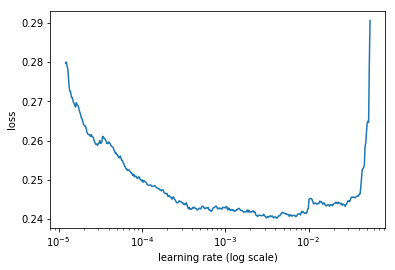

In [51]:
learner.sched.plot()

A learning rate of 10-3 seems like a reasonable choice.

In [55]:
lr = 1e-3

### Training 1st approximation

Train the model for 3 epochs with the chosen learning rate.

In [56]:
learner.fit(lr, n_cycle=1, metrics=[RMSE])

epoch      trn_loss   val_loss   RMSE                        
    0      0.236226   0.234177   0.234177  



[array([0.23418]), 0.2341774404318412]

### Mini-batch gradient descent with restarts
We can relate the "size" of the local minimum to the generalitzation it can achieve.<br>
I like to think that noise has this cahotic highly variant nature whereas the perception we are looking for has a much more stable and invariant nature.<br>
It makes sense then that a huge stable local minimum predicts more on the perception than the noise.<br>
Using this theory we will restart the learning sheduler to unconverge from "small" local minimums in the hope to find a better "big" more generalitzating minimum.

### Training 2nd approximation
Train the model with the chosen learning rate for 3 epochs with a cycle len of 2.<br>

In [428]:
start = time.time()
learner.fit(lrs=lr, n_cycle=3, cycle_len=1, metrics=[RMSE])
end = time.time()
print(f"Total seconds elapsed: {end-start}")

epoch      trn_loss   val_loss   RMSE                        
    0      0.159318   0.250217   0.250217  
    1      0.14161    0.249672   0.249672                    
 10%|█         | 74/705 [00:04<00:37, 16.94it/s, loss=0.123]

KeyboardInterrupt: 

 10%|█         | 74/705 [00:20<02:50,  3.70it/s, loss=0.123]

### Training 3d approximation

To fine tune our model we will unfreeze some previous layers.

Neural nets use a chain of abstractions to build a perception. The early layers work on general abstract patter recognition like edges or textures.<br>
To solve a particular problem, we will train the last layers to adapt to that particular problem. However, early layers don't have to be tuned that much thanks to their general nature.<br>
For that reason, we define an array of learning rates from the earlier layers to the latest.<br>
We divide the neural net in three parts, starting from the end, each earlier layer has a e-1 learning rate in respect to the next one.

In [400]:
lr=np.array([1e-6,1e-5,1e-4])

As we are approaching a more general minimum with SGDR (Stochastic Gradient Descent with Restarts) we would like to take longer to restart so our algorithm can converge.<br>
Cycle_mult does that, everytime a cycle ends the next cycle will be of length cycle_mult * previous_cycle.<br>
In this case: [1,2,4] for a total of 7 cycles.

In [402]:
start = time.time()
learner.fit(lr, n_cycle=3, cycle_len=1, metrics=[RMSE])
end = time.time()
print(f"Total seconds elapsed: {end-start}")

 30%|██▉       | 211/705 [00:02<00:06, 75.42it/s, loss=0.229]
epoch      trn_loss   val_loss   RMSE                        
    0      0.228069   0.233174   0.233174  
    1      0.22603    0.233201   0.233201                    
    2      0.227795   0.233265   0.233265                    

Total seconds elapsed: 28.61696720123291


## Model predictions

In [ ]:
processed_train_df, y, nas, mapper = proc_df(train_sample_df, dependant_f, do_scale=True)

In [ ]:
processed_test_df , _, test_nas, test_mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)